In [1]:
import os

In [2]:
%pwd 

'c:\\Users\\ahmed\\OneDrive\\Documents\\Documents\\coding\\data science\\DataScience\\MLOPS-Project\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd 

'c:\\Users\\ahmed\\OneDrive\\Documents\\Documents\\coding\\data science\\DataScience\\MLOPS-Project'

## steps to connect to mlflow with dagshub

* Generate an Access Token in DagsHub

* Go to your DagsHub profile → Settings → Access Tokens.

* Create a Personal Access Token.

* Copy it somewhere safe (you’ll need it only once).

########################################

* Type in power shell:

* setx MLFLOW_TRACKING_URI "https://dagshub.com/username/repo.mlflow"
* setx MLFLOW_TRACKING_USERNAME "<your-dagshub-username>"
* setx MLFLOW_TRACKING_PASSWORD "<your-access-token>"

* restart your terminal after executing these

###############################################


* import mlflow

--> MLflow will automatically use the environment variables
* mlflow.set_tracking_uri("https://dagshub.com/username/repo.mlflow")

In [5]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/am6499057/MLOPS-Project.mlflow")
# mlflow.set_experiment("my-experiment")


## entity

In [6]:
from dataclasses import dataclass 
from pathlib import Path 

@dataclass(frozen= True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict 
    metric_file_name: Path
    target_column: str 
    mlflow_uri: str

## config manager

In [7]:
from mlproject.constants import * 
from mlproject.utils.common import read_yaml, create_directories

class ConfigurationManager():
    def __init__(self,
                 config_filepath = CONFIG_FILE_PATH,
                 params_filepath = PARAMS_FILE_PATH,
                 schema_filepath = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.LogisticRegression
        schema = self.schema.TARGET_COLUMN 

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir = config.root_dir,
            test_data_path = config.test_data_path,
            model_path = config.model_path,
            all_params = params,
            metric_file_name = config.metric_file_name,
            target_column = schema.name,
            mlflow_uri = "https://dagshub.com/am6499057/MLOPS-Project.mlflow"
        )

        return model_evaluation_config
    

## Component

In [8]:
import os
import pandas as pd 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse 
import mlflow
import mlflow.sklearn 
import numpy as np
import joblib

from mlproject.utils.common import save_json 


class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def eval_metrics(self, actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2
    
    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        model = joblib.load(self.config.model_path)

        x_test = test_data.drop([self.config.target_column], axis=1)
        y_test = test_data[[self.config.target_column]]

        mlflow.set_registry_uri(self.config.mlflow_uri) # setting up my tracking uri, bcuz i want to do it in the remote server.
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():
            predicted_qualities = model.predict(x_test)

            (rmse, mae, r2) = self.eval_metrics(y_test, predicted_qualities)

            # save metrics as local

            scores = {'rmse': rmse, 'mae': mae, 'r2': r2}
            save_json(path= Path(self.config.metric_file_name), data = scores)

            mlflow.log_params(self.config.all_params)

            mlflow.log_metric('rmse', rmse)
            mlflow.log_metric('r2', r2)
            mlflow.log_metric('mae', mae)

            if tracking_url_type_store != 'file':


                mlflow.sklearn.log_model(model, 'model', registered_model_name='LogosticRegressionModel')
            else:
                mlflow.sklearn.log_model(model, 'model')
                

In [ ]:
# just checking if mlflow is connected
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: https://dagshub.com/am6499057/MLOPS-Project.mlflow


## Pipeline

In [10]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config = model_evaluation_config)
    model_evaluation_config.log_into_mlflow()
except Exception as e:
    raise e 


[2025-09-10 09:28:58,649: INFO: common: yaml file: config\config.yaml, loaded successfully]
[2025-09-10 09:28:58,654: INFO: common: yaml file: params.yaml, loaded successfully]
[2025-09-10 09:28:58,657: INFO: common: yaml file: schema.yaml, loaded successfully]
[2025-09-10 09:28:58,662: INFO: common: created directory at: artifacts]
[2025-09-10 09:28:58,664: INFO: common: created directory at: artifacts/model_evaluation]
[2025-09-10 09:29:00,030: INFO: common: json file saved at: artifacts\model_evaluation\metrics.json]


2025/09/10 09:29:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogosticRegressionModel'.
2025/09/10 09:29:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogosticRegressionModel, version 1
Created version '1' of model 'LogosticRegressionModel'.


🏃 View run likeable-whale-933 at: https://dagshub.com/am6499057/MLOPS-Project.mlflow/#/experiments/0/runs/50d3a3fd41794735beeef38d400ccc07
🧪 View experiment at: https://dagshub.com/am6499057/MLOPS-Project.mlflow/#/experiments/0


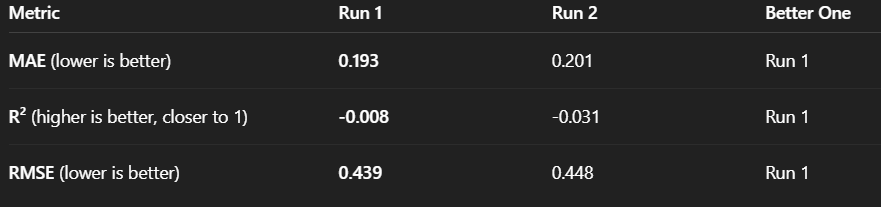

run 1: max_iter at 5000
run 2: max_iter at 2500